### Transform mpiblib output parameter measurements to taulop-Lib parameter format.

In [303]:
import pandas            as pd
import numpy             as np 
import matplotlib        as mpl
import matplotlib.pyplot as plt

In [304]:
# configuration

channels = ["SHM", "TCP", "IB"]

path = "/Users/jarico/Documents/Investigacion/Software/taulop-tool/taulopparameters/mpiblib-params/parameters/param_data/Metropolis/02"


In [305]:
    
def getOverheadMapping(lines, mapping):
    
    P = 0
    
    for i in range(0, len(lines)):
        
        value = lines[i][1:-1]  # Avoid first character (#) and last "\n"
        
        v = value.split("\t")
                
        if v[0] == "P":
            P = int(v[1])
            continue
            
        if v[0] == "rank":
            continue
            
        if i > P+1:
            break
            
        rank = int(v[0])
        node = v[1]
                
        mapping[rank] = node
    
    return P




In [306]:
def getValue (value):
    
    try:
        return int(value)
    except ValueError: 
        None
        
    try:
        return float(value)
    except ValueError: 
        None
        
    return str(value)    


In [307]:
    
def getOverheadConfig(lines, config):
    
    P = config["P"]
    
    for i in range(P+3, len(lines)): # Starting after mapping lines
        
        value = lines[i][1:-1]       # Avoid first character (#) and last "\n"
        
        v = value.split("\t")
        
        if v[0] == "size":
            break
            
        # Read key and value:
        key   = v[0]        
        value = getValue(v[1])       # Depends on the type of the value
                
        # Set entry
        config[key] = value
                
    return




In [308]:
    
def getOverheadTimes(lines, times):
        
    sizes = 0
    for i in range(0, len(lines)):     # Starting after mapping lines
        
        value = lines[i][0:-1]         # Avoid last "\n"
        
        v = value.split("\t")
        
        sizes += 1

        if (v[0] == "#size"):
            break
                    

    for i in range(sizes, len(lines)): # Starting after mapping lines
        
        value = lines[i][0:-1]         # Avoid last "\n"        
        v = value.split("\t")
                    
        # Read key and value:
        key   = int(v[0])        
        value = float(v[1])            # Depends on the type of the value
                
        # Set entry
        times[key] = value
                
    return



In [309]:
    
def getTransferTimes(lines, P, times):
        
    sizes = 0
    for i in range(0, len(lines)):     # Starting after mapping lines
        
        value = lines[i][0:-1]         # Avoid last "\n"
        
        v = value.split("\t")
        
        sizes += 1

        if (v[0] == "#size"):
            break
                    

    for i in range(sizes, len(lines)): # Starting after mapping lines
        
        value = lines[i][0:-1]         # Avoid last "\n"        
        v = value.split("\t")
        
        # Read key:
        key   = int(v[0])        

        # Read values
        values = []
        for p in range (0, P):        
            values.append(float(v[p+1]))

        # Set entry
        times[key] = values
                
    return



In [310]:
# Operations implemented to measure parameters in different machines, channels, protocols, ...
# Defined in
#   Juan-Antonio Rico-Gallego, Juan-Carlos Díaz-Martín, Alexey L. Lastovetsky, 
#   "Extending τ-Lop to model concurrent MPI communications in multicore clusters",
#   Future Generation Computer Systems, Volume 61, 2016, Pages 66-82, ISSN 0167-739X,
#   https://doi.org/10.1016/j.future.2016.02.021.


# Measuring overhead for eager protocol in all channels.
# It sends messages of size 0 using MPI_Send, hence:
#
#    RTT^c(m=0) = 2 x [o^c(m) + SUM L^c(0, 1)] => o^c(m) = RTT^c(0) / 2
#
def RTT (rtt):
    o = rtt / 2.0
    return o



# Measuring overhead for rendezvous protocol in all channels.
# It sends messages of size 0 using MPI_Ssend, hence
#
#    Ping^c(m=0) = o^c(m) + SUM L^c(0, 1) => o^c(m) = Ping^c(0)
#
def Ping (ping):
    o = ping
    return o



# Measuring transfer time in shared memory, with m < S and t concurrent processes.
# A rank r sends a message to rank r+1 and receives from r-1 using MPI_Sendrecv.
#
#    Ring^0_t(m) = o^0(m) + 2 x L^0(m, t) => L^0(m, t) = [Ring^0_t (m) - o^c(m)] / 2
#
def Ring_SHM (ring, o):
    L = (ring - o) / 2.0
    return L



# Measuring transfer time in shared memory, with m >= S and t concurrent processes.
# A rank r sends a message to rank r+1 and receives from r-1 using MPI_Sendrecv.
#
#    Ring^0_t(m) = o^0(m) + 2 x k x L^0(S, t) => 
#       L^0(m, t) = [Ring^0_t (m) - o^c(m)] / (2 k) + <rest of last segment>
#
# TODO: last segment.
def Ring_SHM_segm (ring, o, S, m):
    k      = m / S
    last_s = 0
    last_L = 0
    L = (ring - o) / (2 * k) + last_L
    return L



# Measuring transfer time in TCP, with t concurrent processes.
# A rank r sends a message to rank r+1 and receives from r-1 using MPI_Sendrecv.
#
#    Ring^TCP_t(m) = 2 x [o^TCP(m) + 2 x L^0(m, t) + L^TCP(m, t)] => 
#       L^TCP(m, t) = [Ring^TCP_t (m) / 2] - o^TCP(m) - 2 x L^0(m, t)
#
def Ring_TCP (ring, o, L0):
    L_tcp = (ring / 2.0) - o - (2 * L0)
    return L_tcp



# Measuring transfer time in channels with RDMA, with t concurrent processes.
# A rank r sends a message to rank r+1 and receives from r-1 using MPI_Sendrecv.
#
#    Ring^RDMA_t(m) = 2 x [o^NET(m) + L^RDMA(m, t)] => 
#       L^RDMA(m, t) = [Ring^TCP_t (m) / 2] - o^NET(m)
#
def Ring_RDMA (ring, o):
    L = (ring / 2.0) - o
    return L


In [311]:
# Overhead is computed in shared memory using:

# For eager protocol (m < H), a ping pong algorithm.
# For rendezvous protocol (m >= H), a Round Trip Time (RTT).

# Overhead is computed in networks using:

# For eager protocol (m < H), a ping pong algorithm.
# For rendezvous protocol (m >= H), a Round Trip Time (RTT).


def processOverheadSHM_eager (overhead):
    return RTT(overhead)


def processOverheadSHM_rndv  (overhead):    
    return Ping(overhead)


def processTransferTimeSHM_noseg (transfert, overhead):
    return transfert.subtract(overhead, axis=0) / 2.0


def processTransferTimeSHM_seg (transfert, overhead, S):
    
    k = transfert.index // S
    # TODO: Esto tiene miga.
    # seg = transfert.subtract(overhead, axis=0) / (2.0 * k)
    
    # BY NOW: no segmented:
    return transfert.subtract(overhead, axis=0) / 2.0


def processOverheadNET_eager (overhead):
    return RTT(overhead)


def processOverheadNET_rndv  (overhead):    
    return Ping(overhead)


def processTransferTimeTCP (transfert, overhead, L0):
    transfert = transfert / 2.0
    transfert.subtract(overhead, axis=0)
    transfert.subtract(2 * L0, axis=0)
    return transfert


def processTransferTimeRDMA (transfert, overhead):
    transfert = transfert / 2.0
    transfert.subtract(overhead, axis=0)
    return transfert





def process(channel, config, times):
    
    H = config['H']
    P = config['P']
    S = config['S']
    
    if channel == "SHM":
        
        # 1. Overhead
        overhead = times['o(m)']
        
        # 1a) overhead with eager protocol (m < H)
        overhead.loc[:H-1] = processOverheadSHM_eager(overhead.loc[:H-1])
        # 1b OVerhead with rendezvous protocol (m >= H)
        overhead.loc[H:]   = processOverheadSHM_rndv(overhead.loc[H:])
        
        times['o(m)'] = overhead
        
    
        # 2. Transfer time
        transfert = times.loc[:, times.columns[1:]] # T(m,1) ... T(m,P)

        # 2a. No segmented messages: m < S
        transfert_noseg = times.loc[0:S-1, times.columns[1:]]
        overhead_noseg  = times.loc[ :S-1, 'o(m)']            
        transfert_noseg = processTransferTimeSHM_noseg(transfert_noseg, overhead_noseg)
        times.loc[0:S-1, times.columns[1:]] = transfert_noseg

        # 2b. Segmented messages: m >= S
        transfert_seg   = times.loc[S: , times.columns[1:]]
        overhead_seg    = times.loc[S: , 'o(m)']            
        transfert_seg   = processTransferTimeSHM_seg(transfert_seg, overhead_seg, S)
        times.loc[S: , times.columns[1:]] = transfert_seg
            
            
            
    
    if channel == "TCP":
        
        # 1. Overhead: same as SHM and standard for all channels.
        overhead = times['o(m)']
        
        # 1a) overhead with eager protocol (m < H)
        overhead.loc[:H-1] = processOverheadNET_eager(overhead.loc[:H-1])
        # 1b OVerhead with rendezvous protocol (m >= H)
        overhead.loc[H:]   = processOverheadNET_rndv(overhead.loc[H:])
        
        times['o(m)'] = overhead
        
    
        # 2. Transfer time
        transfert = times.loc[:, times.columns[1:]] # T(m,1) ... T(m,P)

        # 2a. No segmented messages along all sizes (segmentation is in TCP/IP protocol)
        transfert = times.loc[:, times.columns[1:]]
        overhead  = times.loc[:, 'o(m)']  
        # TODO: L0 should take a value to invoke:
        transfert = processTransferTimeTCP (transfert, overhead, 0.0)
        times.loc[:, times.columns[1:]] = transfert


        
    if channel == "IB":

        # 1. Overhead: same as SHM and standard for all channels.
        overhead = times['o(m)']
        
        # 1a) overhead with eager protocol (m < H)
        overhead.loc[:H-1] = processOverheadNET_eager(overhead.loc[:H-1])
        # 1b OVerhead with rendezvous protocol (m >= H)
        overhead.loc[H:]   = processOverheadNET_rndv(overhead.loc[H:])
        
        times['o(m)'] = overhead
        
    
        # 2. Transfer time
        transfert = times.loc[:, times.columns[1:]] # T(m,1) ... T(m,P)

        # 2a. No segmented messages along all sizes
        transfert = times.loc[:, times.columns[1:]]
        overhead  = times.loc[:, 'o(m)']  
        transfert = processTransferTimeRDMA (transfert, overhead)
        times.loc[:, times.columns[1:]] = transfert

        
        
        
    if channel == "ARIES":
        # 1. Overhead: same as SHM and standard for all channels.
        overhead = times['o(m)']
        
        # 1a) overhead with eager protocol (m < H)
        overhead.loc[:H-1] = processOverheadNET_eager(overhead.loc[:H-1])
        # 1b OVerhead with rendezvous protocol (m >= H)
        overhead.loc[H:]   = processOverheadNET_rndv(overhead.loc[H:])
        
        times['o(m)'] = overhead
        
    
        # 2. Transfer time
        transfert = times.loc[:, times.columns[1:]] # T(m,1) ... T(m,P)

        # 2a. No segmented messages along all sizes
        transfert = times.loc[:, times.columns[1:]]
        overhead  = times.loc[:, 'o(m)']  
        transfert = processTransferTimeRDMA (transfert, overhead)
        times.loc[:, times.columns[1:]] = transfert

        
        
    return 


In [312]:
def generateChannel(channel, savefile=True, plot=False):

    mapping  = dict()
    config   = dict()
    o_times  = dict()
    tt_times = dict()

    overhead_name  = path + "/" + "overhead_"     + channel + ".txt"
    transfert_name = path + "/" + "transfertime_" + channel + ".txt"


    # 1. Read lines of the overhead_XXX and transfertime_XXX.txt files:
    with open(overhead_name) as f_overhead:

        o_lines = f_overhead.readlines()

        f_overhead.close()


    with open(transfert_name) as f_transfert:

        tt_lines = f_transfert.readlines()

        f_transfert.close()




    # 2. Get data from file "overhead_xxx.txt"

    # 2a. Get data -> Mapping
    P = getOverheadMapping(o_lines, mapping)

    # 2b. Get data -> Config
    config["P"] = P
    getOverheadConfig(o_lines, config)

    # 2c. Get data -> times
    getOverheadTimes(o_lines, o_times)




    # 3. Get data from file "transfertime_xxx.txt"

    # 3a & 3b: assuming same config and mapping than in overhead.

    # 3c. Get data -> times
    getTransferTimes(tt_lines, P, tt_times)




    # 4. Process data according to overhead and transfer time measurements
    #    [FGCS, 2016]

    # 4a. Create Pandas in order to manipulate data
    cols = ['o(m)'] + ['T(m, {})'.format(i) for i in range(1, P+1)]

    o_array = np.array([list(o_times.values())]).T  # Rows = m, Cols = o(m)
    t_array = np.array(list(tt_times.values()))     # Rows = m, Cols = T(m,1) ... T(m, P)

    times = pd.DataFrame(np.concatenate((o_array, t_array), axis=1),
                         columns = cols,
                         index   = o_times.keys())

    num_m = o_array.shape[0]
    
    # 4b. Process overhead and transfer time according to communication channel
    process(channel, config, times)
    # change columns names, now they are o,L
    cols = ['o(m)'] + ['L(m, {})'.format(i) for i in range(1, P+1)]
    times.set_axis(cols, axis=1, inplace=True)


    # 5. Print values
    #print("Configuration data: ")
    #print(config)

    #print("Mapping data: ")
    #print(mapping)

    #print("Overhead Times data: ")
    #print(o_times)

    #print("Transfer Times data: ")
    #print(tt_times)




    # 6. Save parameter files.
    if savefile:
        cols = ['m'] + cols
        filename = path + "/" + channel + ".txt"

        with open(filename, 'w') as f:
            f.write('#m\t'   + str(num_m)       + "\n")
            f.write('#tau\t' + str(config['P']) + "\n")
            f.write("#" + '\t'.join(cols) + "\n")

            for m, t in times.iterrows():
                t_str = '\t'.join(str("{:.12f}".format(i)) for i in t.values)
                f.write(str(m) + '\t' + t_str + "\n")

        f.close()



    # 7. Plot values.
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=80, sharex=True)

        x = np.arange (1, num_m+1)

        ax[0].plot(x, times['o(m)'])
        ax[0].set_title("Overhead - o(m)")
        ax[0].xaxis.set_ticks(x)
        ax[0].set_xticklabels(times.index, rotation=45)
        ax[0].set_xlabel("m (bytes)")
        ax[0].set_ylabel("time (secs)")

        for p in range(1, P+1):
            y = times.iloc[:, p] # BANDWIDTH??: / times.index
            ax[1].plot(x, y)
        ax[1].set_title("Transfer time - L(m,t)")
        ax[1].set_xticklabels(times.index, rotation=45)
        ax[1].set_ylabel("time (secs)")

        fig.suptitle("Times for " + channel)
        plt.show()

        
    return

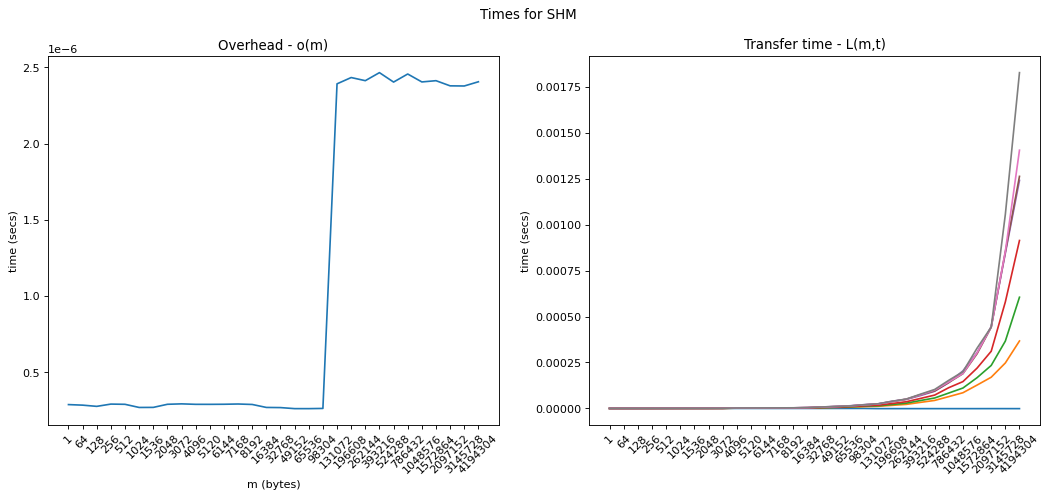

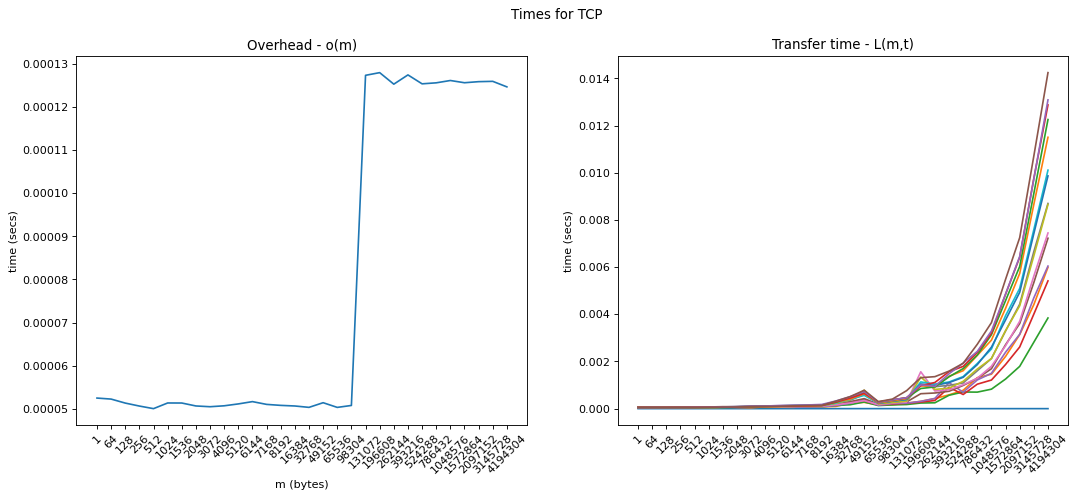

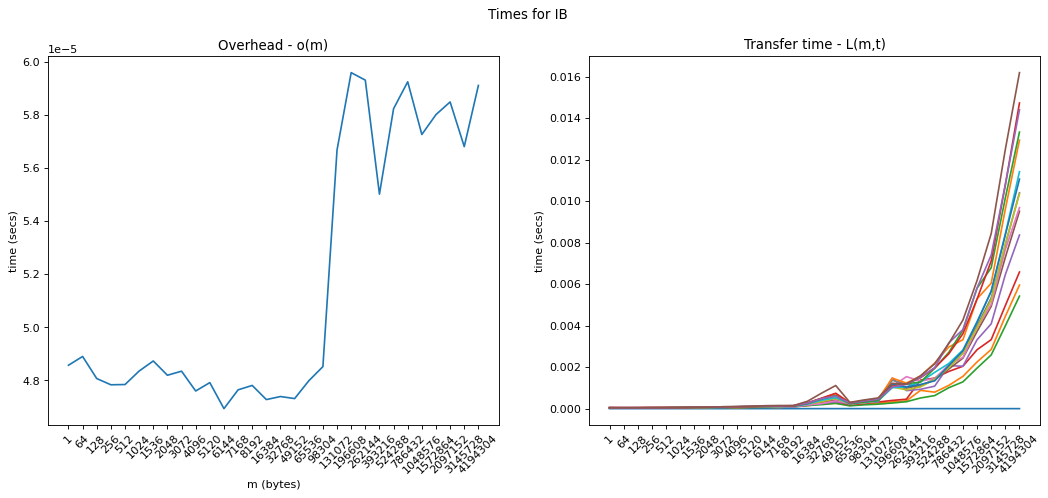

In [313]:
# main

if __name__ == "__main__":
    
    for channel in channels:
        
        generateChannel(channel, savefile=True, plot=True)
